## Importa Librerie

In [39]:
# Numpy-Pandas-Matplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
%matplotlib nbagg

# file di funzioni-utility
import VF as vf

## Importa Dati

In [34]:
bs_coordinates, traces = vf.get_data()

ID = 75533
traces = traces[traces['id'] == ID]


raw_data = traces.drop(['id'], axis=1)
raw_data = raw_data.drop(['speed'], axis=1)
raw_data = raw_data.drop(['C'], axis=1)
raw_data = raw_data.drop(['C+1'], axis=1)
raw_data = raw_data.drop(['C-1'], axis=1)
raw_data = raw_data.drop(['C-2'], axis=1)
raw_data = raw_data.drop(['C-3'], axis=1)


# Estrai la traccia continua più lunga
time_line = raw_data['time'].values
longest_seq = max(np.split(time_line, np.where(np.diff(time_line) != 1)[0]+1), key=len).tolist()    

#raw_data = raw_data[raw_data['time'].isin([longest_seq])]

raw_data = raw_data[(raw_data['time'] >= longest_seq[0]) & (raw_data['time'] <= longest_seq[-1])]             
print(raw_data)               
                    

# Drop header and row-index -> numpy-array matrix
raw_values = raw_data.values

print('Struttura dati:', raw_values.shape)


           time             x             y
775196  62305.0  13192.846656  13204.430352
775197  62306.0  13196.202474  13211.824463
775198  62307.0  13200.422222  13221.176525
775199  62308.0  13205.492462  13232.448715
775200  62309.0  13210.793230  13244.471366
...         ...           ...           ...
775307  62416.0  12706.090194  13848.783626
775308  62417.0  12701.091535  13872.594323
775309  62418.0  12702.453845  13885.407619
775310  62419.0  12701.991380  13898.499453
775311  62420.0  12701.503851  13912.300845

[116 rows x 3 columns]
Struttura dati: (116, 3)


In [42]:
raw_data = pd.read_csv('Traces/75533_T.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# Drop ID column
raw_data = raw_data.drop(['id'], axis=1)
raw_data = raw_data.drop(['speed'], axis=1)

# Converto i tempi in interi
#raw_data = raw_data.astype({'time': 'int32'})

# Drop header and row-index -> numpy-array matrix
raw_values = raw_data.values

print('Struttura dati:', raw_values.shape)

FileNotFoundError: [Errno 2] File b'Traces/75533_T.csv' does not exist: b'Traces/75533_T.csv'

## Istanziare il modello di Regressione

In [35]:
# Istanziare il modello di regressione lineare
regr_x = linear_model.LinearRegression()
regr_y = linear_model.LinearRegression()

# Dimensione della finestra di apprendimento
wnd_size = 5

# Inizializzazione liste per predizioni
pred_x = []
pred_y = []
MSE = []



# Ciclo per predizioni
for i in range(wnd_size +1, len(raw_values)):
    
    # Vettore contenente i tempi della finestra
    times = raw_values[i - wnd_size - 1 : i - 1, 0]
    
    # Se abbiamo un errore alto -> aggiustare l'ultima posizione per predire meglio la successiva
    if len(pred_x) > 0 and MSE[-1] > 10:
        last_pos = np.array([raw_values[i-1, 1], raw_values[i-1, 2]])
        last_pred = np.array([pred_x[-1], pred_y[-1]])
        
        # Calcola angolo in radianti (-pi, pi)
        angle = np.arctan2((last_pos[0] - last_pred[0]), (last_pos[1] - last_pred[1]))
        
        # Conversione radianti -> gradi -> print(angle * 180 / np.pi)
        train_x = np.copy(raw_values[i - wnd_size - 1 : i - 1, 1])
        train_y = np.copy(raw_values[i - wnd_size - 1 : i - 1, 2])
        
        
        # Cambia le coordinate dell'ultima posizione per cercare di correggere
        delta_error = 4 * np.array([last_pos[0] - last_pred[0], last_pos[1] - last_pred[1]])
        train_x[2] = train_x[2] + delta_error[0]
        train_y[2] = train_y[2] + delta_error[1]
    else:
    
        # Altrimenti usare le posizioni vecchie normalmente
        # Vettori contenenti le coordinate x e y della finestra
        train_x = np.copy(raw_values[i - wnd_size - 1 : i - 1, 1])
        train_y = np.copy(raw_values[i - wnd_size - 1 : i - 1, 2])
    '''
    
    # Vettori contenenti le coordinate x e y della finestra
    train_x = np.copy(raw_values[i - wnd_size - 1 : i - 1, 1])
    train_y = np.copy(raw_values[i - wnd_size - 1 : i - 1, 2])
    '''
    # Tempo della posizione da predire
    cur_t = raw_values[i, 0]
    
    # Reshape in colonne
    times = times.reshape(-1, 1)
    train_x = train_x.reshape(-1, 1)
    train_y = train_y.reshape(-1, 1)
    cur_t = cur_t.reshape(-1, 1)
    
    # Train LR
    regr_x.fit(times, train_x)
    regr_y.fit(times, train_y)

    # Predizione Coordinate
    p_x = regr_x.predict(cur_t)
    p_y = regr_y.predict(cur_t)
    
    pred_x.append(p_x[0][0])
    pred_y.append(p_y[0][0])
    
    #print('Posizione vera: ', raw_values[i, 1], raw_values[i, 2])
    #print('Posizione predetta: ', p_x[0][0], p_y[0][0])
    
    e1 = np.linalg.norm(np.subtract([p_x[0][0], p_y[0][0]], [raw_values[i, 1], raw_values[i, 2]]))
    e2 = mean_squared_error([p_x[0][0], p_y[0][0]], [raw_values[i, 1], raw_values[i, 2]])
    
    MSE.append(e1)
    #print(f'Errore numpy: {e1}')
    #print(f'Errore sklearn: {e2}')
    
print(np.mean(MSE))

6.978203902580677


## Preparazione dei Dati per Animazione del Percorso

In [65]:
# Voglio i dati in forma [frame, N-variabili, 2-(x, y)]

positions = np.zeros((len(raw_values), 2, 2))
counter = wnd_size + 1
print(positions.shape)

for pos in positions:
    
    # Uscita di sicurezza :P
    if counter >= len(raw_values):
        break
        
        
    # Posizione attuale
    pos[0] = raw_values[counter, 1:3]

    # Posizione predetta
    pos[1][0] = np.array(pred_x[counter - wnd_size - 1])
    pos[1][1] = np.array(pred_y[counter - wnd_size - 1])
    #print(f'{counter}-{pos}')
    counter += 1


(148, 2, 2)


<IPython.core.display.Javascript object>


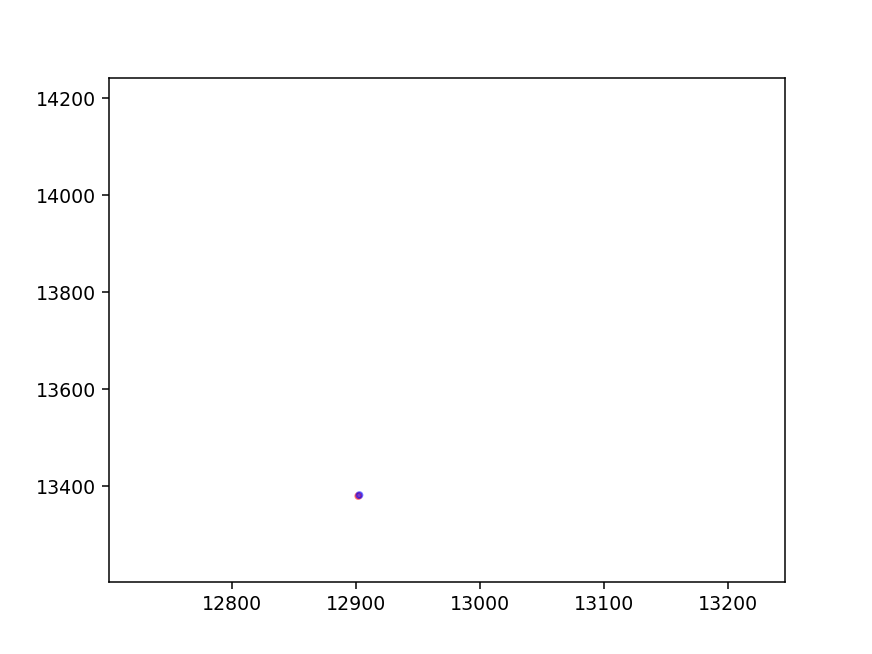

In [72]:
def init():
    scatterplot.set_offsets([[], []])
    return [scatterplot]

def update(i, scatterplot, positions):
    scatterplot.set_offsets(positions[i])
    scatterplot.set_color(['red', 'blue'])
    scatterplot.set_alpha(0.5)
    return [scatterplot]

fig = plt.figure()
scatterplot = plt.scatter([], [], s=10)

# Le limitazioni partono da 1 per evitare il punto iniziale (0,0)
plt.xlim(min(raw_values[1:, 1]), max(raw_values[1:, 1]))
plt.ylim(min(raw_values[1:, 2]), max(raw_values[1:, 2]))

anim = FuncAnimation(fig, update, init_func=init, fargs=(scatterplot, positions), interval=1000, frames=len(positions),
blit=True, repeat=True)
plt.show()

## Test Animazione con Posizione-Predizione separati

In [36]:
# Voglio i dati in forma [frame, N-variabili, 2-(x, y)]

true_pos = np.zeros((len(raw_values), 2, 1))
pred_pos = np.zeros((len(raw_values), 2, 1))

counter = wnd_size + 1

for i in range(len(raw_values)):

    # Uscita di sicurezza :P
    if counter >= len(raw_values):
        break
        
        
    # Posizione attuale
    true_pos[i][0] = raw_values[counter, 1]
    true_pos[i][1] = raw_values[counter, 2]

    # Posizione predetta
    pred_pos[i][0] = pred_x[counter - wnd_size - 1]
    pred_pos[i][1] = pred_y[counter - wnd_size - 1]

    counter += 1
    
print(true_pos[1][0], true_pos[1][1])

[13226.32500048] [13281.02875251]


<IPython.core.display.Javascript object>


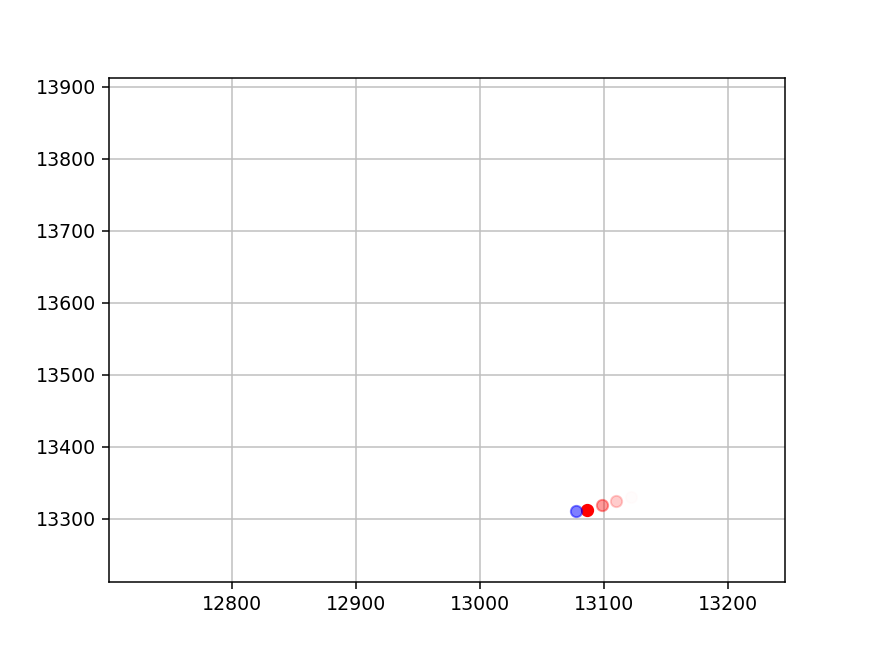

In [40]:
def update(i):
    # Update della traccia
    trace_3.set_data(true_pos[i-3][0], true_pos[i-3][1])
    trace_3.set_color('red')
    trace_3.set_alpha(0.01)
    trace_2.set_data(true_pos[i-2][0], true_pos[i-2][1])
    trace_2.set_color('red')
    trace_2.set_alpha(0.2)
    trace_1.set_data(true_pos[i-1][0], true_pos[i-1][1])
    trace_1.set_color('red')
    trace_1.set_alpha(0.4)
    
    # Update della posizione vera
    true_scatter.set_data(true_pos[i][0], true_pos[i][1])
    true_scatter.set_color('red')
    true_scatter.set_alpha(1)
    
    # Update della predizione
    pred_scatter.set_data(pred_pos[i][0], pred_pos[i][1])
    pred_scatter.set_color('blue')
    pred_scatter.set_alpha(0.5)
    return

# Inizializzazione della figura
fig = plt.figure()
# Aggiunta dell'asse per avere la griglia
ax = fig.add_subplot()
ax.grid(True, linestyle='-', color='0.75')

# Creazione delle posizioni vere e predette
true_scatter, = plt.plot([], [], 'o')
pred_scatter, = plt.plot([], [], 'o')

# Creazione della traccia dietro
trace_1, = plt.plot([], [], 'o')
trace_2, = plt.plot([], [], 'o')
trace_3, = plt.plot([], [], 'o')

# Le limitazioni partono da 1 per evitare il punto iniziale (0,0)
plt.xlim(min(raw_values[1:, 1]), max(raw_values[1:, 1]))
plt.ylim(min(raw_values[1:, 2]), max(raw_values[1:, 2]))

anim = FuncAnimation(fig, update, interval=300, frames=len(true_pos), blit=True, repeat=True)
plt.show()

<IPython.core.display.Javascript object>


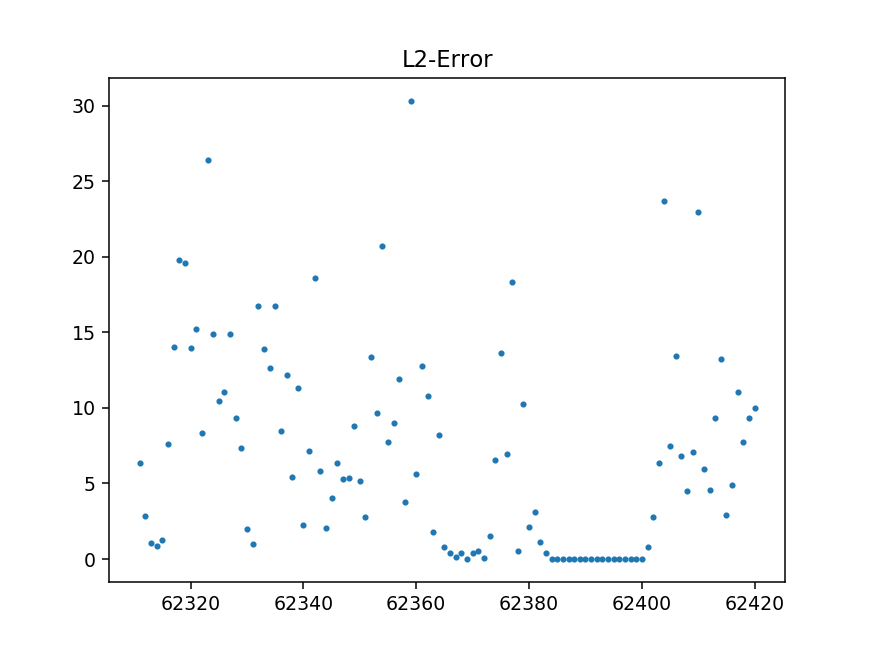

In [41]:


tot_times = raw_values[6:, 0]
plt.figure()
plt.scatter(tot_times, MSE, s=5)
plt.title('L2-Error')
plt.show()


<IPython.core.display.Javascript object>


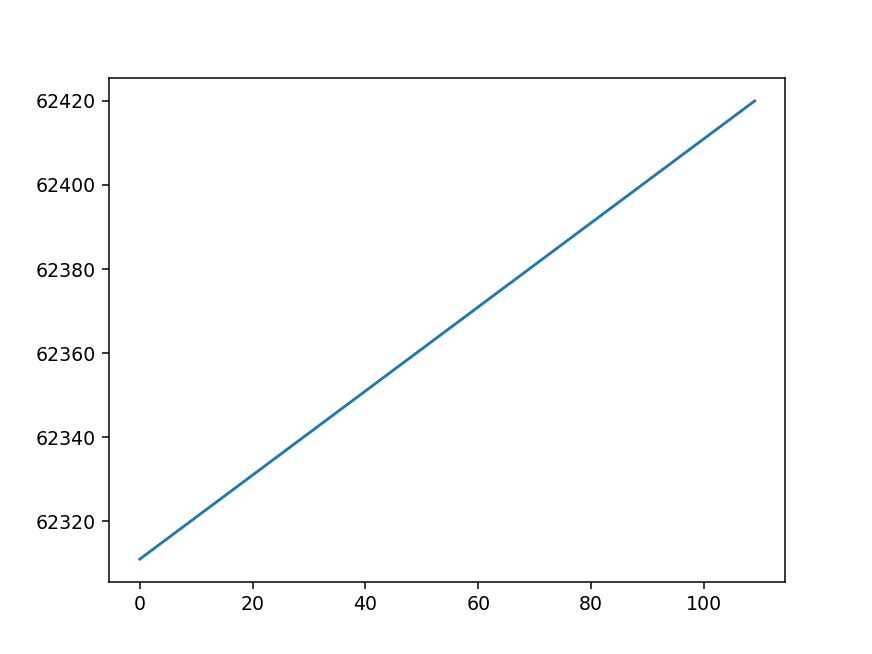

In [42]:
plt.figure()
plt.plot(tot_times)
plt.show()